Overview
-----------

This notebook use [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau, for Classification

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False) # https://github.com/ageron/handson-ml2/issues/518#issuecomment-1001289203
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by scikit-learn generally have a similar dictionary structure, including the following:

- A `DESCR` key describing the dataset
- A `data` key containing an array with one row per instance and one column per feature
- A `target` key containing an array with the labels

In [8]:
import math

data, labels = mnist["data"], mnist["target"]
data.shape

print(
    "There are {0} images, and each image has {1} features. ".format(data.shape[0], data.shape[1]) +
    "This is because each image is {0} × {0} pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).".format(int(math.sqrt(data.shape[1])))
)

There are 70000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).


Let’s take a peek at one digit from the dataset:

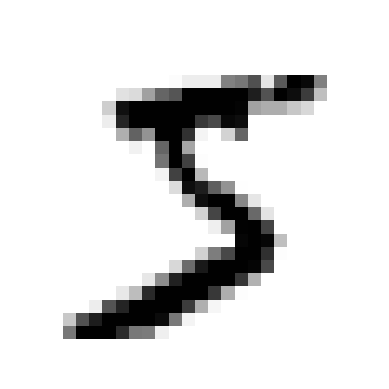

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt

example_digit = data[0]
example_image = data[0].reshape(28, 28)

plt.imshow(example_image, cmap="binary")
plt.axis("off")
plt.show()

In [11]:
print("This is the number '{0}'".format(labels[0]))

This is the number '5'


Let's convert label from string to number to make the following processing easier and split training and test data test

In [14]:
import numpy as np

labels = labels.astype(np.uint8)

NUM_TRAINING_INSTANCES = 60000

training_instances = data[:NUM_TRAINING_INSTANCES]
training_labels = labels[:NUM_TRAINING_INSTANCES]
test_instances = data[NUM_TRAINING_INSTANCES:]
test_labels = labels[NUM_TRAINING_INSTANCES:]

Binary Classifier - Classififying "5"
----------------------------------------

Let's convert the labels to a boolean type where `True` means "is 5" and `False`, otherwise:

In [19]:
training_labels_5 = (training_labels == 5)
test_labels_5 = (test_labels == 5)

training_labels_5

array([ True, False, False, ...,  True, False, False])

### Stochastic Gradient Descent (SGD) Classifier

In [20]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier(random_state=42)
sgd_classifier.fit(training_instances, training_labels_5)

sgd_classifier.predict([example_digit])

array([ True])

Performance Measures
---------------------------

### Cross Validation

We use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with 3 folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, 3), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [21]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, training_instances, training_labels_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Occasionally we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we can implement our own cross-validation. The following code does roughly the same thing as scikit-learn’s `cross_val_score()` function above, and it prints the result in the same ballpark.

We use the `StratifiedKFold` class that performs stratified sampling, i.e. to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(training_instances, training_labels_5):
    sgd_classifier_clone = clone(sgd_classifier)
    
    training_instances_folds = training_instances[train_index]
    training_labels_folds = training_labels_5[train_index]
    
    test_instances_folds = training_instances[test_index]
    test_labels_folds = training_labels_5[test_index]
    
    sgd_classifier_clone.fit(training_instances_folds, training_labels_folds)
    predictions = sgd_classifier_clone.predict(test_instances_folds)
    n_correct = sum(predictions == test_labels_folds)
    print(n_correct / len(predictions))

0.95035
0.96035
0.9604


In [28]:
prob_5 = len([label for label in training_labels_5 if label == True])/len(training_labels_5)

print(
    "This reault, although looks promising, shows little improvements over baseline given that only about " +
    "{0}% of the images are 5's".format(prob_5 * 100)
)

This reault, although looks promising, shows little improvements over baseline given that only about 9.035% of the images are 5's


In [29]:
print(
    "We can have a dummy classifier that always say 'Not a 5' for all training instance that still achive about " +
    "{0}% accuracy".format((1 - prob_5) * 100)
)

We can have a dummy classifier that always say 'Not a 5' for all training instance that still achive about 90.96499999999999% accuracy


This demonstrates why __accuracy is generally not the preferred performance measure for classifiers__, especially when we are dealing with _skewed datasets_ (i.e., when some classes are much more frequent than others).

### Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the __confusion matrix__. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, we would look in the 5th row and 3rd column of the confusion matrix.

We use the `cross_val_predict()` function for this purpose. Just like the `cross_val_score()` used above, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

We assign the clean prediction to a variable named `predictions` which essentially contains the predicted labels for each training instance. Then we use `confusion_matrix()` to get the matrix:

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

predicitons = cross_val_predict(sgd_classifier, training_instances, training_labels_5, cv=3)
confusion_matrix(training_labels_5, predicitons)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an labeled class, while each column repre‐ sents a predicted class.

- The first row of this matrix considers non-5 images (the negative class)

  - The 1st element is the the number of non-5's correctly classified (_true negatives_ or __TN__)
  - The 2nd element is the the number of non-5's misclassified (_false positive_ or __FP__)
  
- The second row considers images of 5's (the positive class)

  - The 1st element is the number of misclassified non-5's (_false negative_ or __FN__)
  - The 2nd element is the number of correctly classified 5's (_true positive_ or __TP__)
  
A perfect classifier would have only true positives and true negatives, so __its confusion matrix would have nonzero values only on its main diagonal__